# SMV2rho: Tutorial 4

In this tutorial we will convert from velocity to density using the new `SMV2rho` approach, which is outlined in Stephenson et al (_in review_)

First let's import the required modules from `SMV2rho`

In [1]:
# import modules
from SMV2rho import plotting as smplt
from SMV2rho import density_functions as smd
from SMV2rho import constants as c

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Class approach

Again we will first go through this procedure step-by-step so that we can query the outputs.

### Load file

Let's define the velocity profile that we are interested in converting, initialise the `Convert` class and read in the profile data file.

In [2]:
# path to test velocity file
#  - this file comes with the distribution so there is no need to change this path
vp_file = "../TEST_DATA/EUROPE/Vp/RECEIVER_FUNCTION/DATA/M19_AQU_Vp.dat"

# load a profile into the Convert class
profile = smd.Convert(vp_file, profile_type = "Vp")

# read data
profile.read_data()

### Convert profile

Now we can convert the profile into density.  To do this, we need to create an object containing all of the parameters needed to convert from $V_P$ into density.  Initially, we will set all arguments to default.  We will not include temperature dependence or compressibility for now.

The parameters will be created by default when we call the get_v_parameters method within the Constants dataclass.  Run the cell below to see how this works.

In [3]:
# create the constants object.  This will store all of the constants we need for the conversion to work.
constants = c.Constants()

# print the contents of the constants dataclass
print(constants)

# call the get_v_constants method asking for Vp constants
constants.get_v_constants('Vp')

# check the variables stored in the constants data class
print(constants)

Constants(vp_constants=None, vs_constants=None, material_constants=None)
Constants(vp_constants=VpConstants(v0=-0.93521, b=0.00169478, d0=2.55911, dp=-0.00047605, c=1.674065, k=0.01953466, m=-0.0004), vs_constants=None, material_constants=None)


See that initially, when we created the constants object, it contains three attributes of `Nonetype`, called `vs_constants`, `vp_constants` and `material_constants`.  These objects are filled with values when the `get_v_constants` or `get_material_constants` methods are called.

Note that the `vp_constants` object is an instance of the `VpConstants` dataclass.  This is just a convenient way to store constant values that are used throughout the program and so don't worry too much if this is not a concept you have come across before!

So we have an object `constants` that is an instance of the `Constants` master dataclass, which contains attributes that are instances of the `VpConstants`, `VsConstants` and the `MaterialConstants` classes.

We can access individual constants like this...

In [4]:
# set the make a new variable called vp_constants that takes only the vp_constants from the constants class
vp_constants = constants.vp_constants

print(vp_constants)

# now let's print the `b` parameter
print(f"b: {vp_constants.b}")

VpConstants(v0=-0.93521, b=0.00169478, d0=2.55911, dp=-0.00047605, c=1.674065, k=0.01953466, m=-0.0004)
b: 0.00169478


So we access the constants just by writing `vp_constants.{parameter_name}`.

Note that we can also set custom values for the constants if we want to.  These are given as keyword arguments after the constant type when calling the `get_v_constants` method.  Let's make a new object called `custom_constants` and set some custom values.  Note that any values not set will be automatically set to the default values specified in the `VsConstants` class in the `constants` module.  You can find these values by typing e.g. `c.VsConstants?`.  The default values are shown under the `Init signature:` and also written in the docstring underneath.

Please see **Stephenson _et al._ (_2024_), JGR: Solid Earth** for information about the constant values.

In [5]:
c.VsConstants?

Init signature:
c.VsConstants(
    v0: float = -0.60777,
    b: float = 0.0010345,
    d0: float = 1.4808,
    dp: float = -0.00029773,
    c: float = 0.7374,
    k: float = 0.020041,
    m: float = -0.00023,
) -> None
Docstring:     
Constants for shear wave velocity (Vs).

Attributes:
v0: float = -6.0777e-01  # Initial velocity at reference conditions
b: float = 1.0345e-03    # Velocity gradient as function of pressure at 
                           constant temperature
d0: float = 1.4808       # Velocity gradient with respect to density at 
                           standard temperature and pressure
dp: float = -2.9773e-04  # Pressure dependence of velocity gradient with 
                           respect to density
c: float = 7.3740e-01    # Exponential drop-off magnitude
k: float = 2.0041e-02    # Exponential drop-off of Vs at low pressure
m: float = -2.3e-4       # Velocity gradient as function of temperature at
                           constant pressure
File:           ~/Wor

In [6]:
custom_constants = c.Constants()

# set custom values for `v0` and `k` and defaults for other constants
custom_constants.get_v_constants('Vs', v0=100, k=20)

print(custom_constants)

Constants(vp_constants=None, vs_constants=VsConstants(v0=100, b=0.0010345, d0=1.4808, dp=-0.00029773, c=0.7374, k=20, m=-0.00023), material_constants=None)


Let's now attempt to run the `v_to_density_stephenson` method of the `Convert` class.  To do this we will run:

```profile.V_to_density_stephenson(vp_constants)```.

This will generate a `ValueError`, because the default setup of the function is to include temperature dependence, which requires more information to be provided.  Since we have not provided the parameter file, attempting to run this function will throw an error.  This error makes sure that we do not include temperature dependence by accident.

In [7]:
# calculate density profile -- note default is the temperature dependence is True!
profile.V_to_density_stephenson(vp_constants)

ValueError: T_dependence is set to True. Please use the Constants class and not the VpConstants or VsConstants classes to store the constants.

This error is thrown because by default, the programme expects that we want to include temperature dependence within the density conversion.  For now we will not incloude temperature dependence.  We will now provide the information that `T_dependence = False`.  This added optional argument will suppress the above error and allow the program to run.  Note that in doing this we are assuming that $V$ and $\rho$ are both unaffected by temperature, $T$, and that we don't need to account for compressibility.

Running this function may result in an integration warning.  This warning can be safely ignored and is generated because the velocity and density profile functions $V_P(z)$ and $\rho (z)$ contain discontinuities.

In [8]:
# calculate density profile -- note default is the temperature dependence is True!
profile.V_to_density_stephenson(vp_constants, T_dependence = False)

# check the keys in the profile.data object
profile.data.keys()

/Users/eart0518/Work/SMV2rho/src/SMV2rho/density_functions.py:1598: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_val = integrate.quad(interp_profile, bins_low_res[e],


dict_keys(['station', 'Vp_file', 'region', 'moho', 'location', 'av_Vp', 'Vp', 'type', 'method', 'rho', 'av_rho', 'rho_hi_res', 'Vp_hi_res', 'p'])

### Outputs and plotting

We now have a number of new fields that have appeared in our `profile.data` dictionary.  We have, as before, `'rho'` and `'av_rho'` fields, but now we also have `'rho_hi_res'`, `'Vp_hi_res'` and `'p'` fields.  These fields are generated because the velocity profile must be discretized in order to calculate pressure, $p$ as a function of depth, which is in turn needed for the density conversion.  Let's have a look at them.

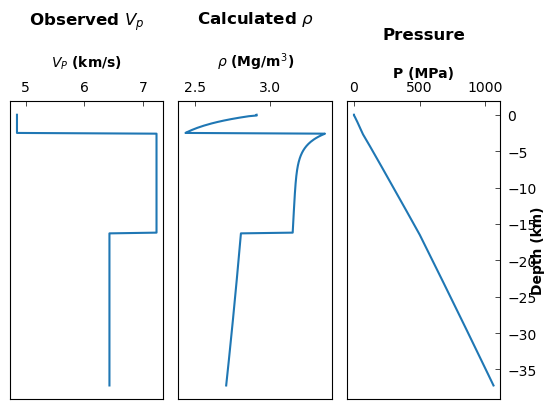

In [9]:
# Define plot settings
plot_type = 'line'
titles = [r'Observed ${V_p}$', r'Calculated $\rho$', 'Pressure']
xlabels = [r'${V_P}$ (km/s)', r'$\rho$ (Mg/m${^3}$)', 'P (MPa)']
ylabels = ['Depth (km)', 'Depth (km)', 'Depth (km)']

# data1, data2 and data3 -- list of dictionaries for each panel for each data series.
data1 = [{'x': profile.data["Vp_hi_res"][:,1], 'y': profile.data["Vp_hi_res"][:,0]}]
data2 = [{'x': profile.data["rho_hi_res"][:,1], 'y': profile.data["rho_hi_res"][:,0]}]
data3 = [{'x': profile.data["p"][:,1], 'y': profile.data["p"][:,0]}]

# Call the plot_panels function
smplt.plot_panels([data1, data2, data3], plot_type=plot_type, 
            cmap=None, titles=titles, 
            xlabels=xlabels, ylabels=ylabels,
            z_values=None, figure_scale=0.7, 
            save_path=None)

We see that $\rho(z)$ is now varing within layers.  this behaviour arises because the `SMV2rho` density conversion scheme is pressure-dependent.  Density is binned into the same depth intervals as the velocity profile during the conversion process adn we can take a look at that below with the `'rho'` key...

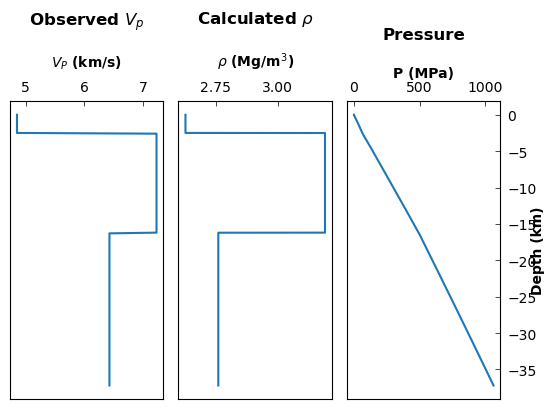

In [10]:
# Define plot settings
plot_type = 'line'
titles = [r'Observed ${V_p}$', r'Calculated $\rho$', 'Pressure']
xlabels = [r'${V_P}$ (km/s)', r'$\rho$ (Mg/m${^3}$)', 'P (MPa)']
ylabels = ['Depth (km)', 'Depth (km)', 'Depth (km)']

# data1, data2 and data3 -- list of dictionaries for each panel for each data series.
data1 = [{'x': profile.data["Vp_hi_res"][:,1], 'y': profile.data["Vp_hi_res"][:,0]}]
data2 = [{'x': profile.data["rho"][:,1], 'y': profile.data["rho"][:,0]}]
data3 = [{'x': profile.data["p"][:,1], 'y': profile.data["p"][:,0]}]

# Call the plot_panels function
smplt.plot_panels([data1, data2, data3], plot_type=plot_type, 
            cmap=None, titles=titles, 
            xlabels=xlabels, ylabels=ylabels,
            z_values=None, figure_scale=0.7, 
            save_path=None)

Notice the resolution of the density profile is now the same as the velocity profile.  This functionality only works well if the velocity profile does not have vertical gradients within layers.

## Function approach

Again, we can achieve the same outcome by running a wrapper function if users find this approach easier.  Again, we lose some granularity in accessing the class outputs but it may be more straightforward to follow.

We will set `approach = 'stephenson'` and give the programme the parameter file.

In [11]:
# call density conversion function
# note that using profile_type="Vs" first calls a function to convert to Vp
# as is required by Brocher's (2005) approach.
profile_stephenson = smd.convert_V_profile(vp_file, 
                            profile_type="Vp", 
                            approach="stephenson",
                            working_file = True,
                            parameters = vp_constants)

# print the keys to check that the outputs are identical to the class method
profile_stephenson.keys()

working on ../TEST_DATA/EUROPE/Vp/RECEIVER_FUNCTION/DATA/M19_AQU_Vp.dat


dict_keys(['station', 'Vp_file', 'region', 'moho', 'location', 'av_Vp', 'Vp', 'type', 'method', 'rho', 'av_rho', 'rho_hi_res', 'Vp_hi_res', 'p'])

We can now check the output again by plotting...

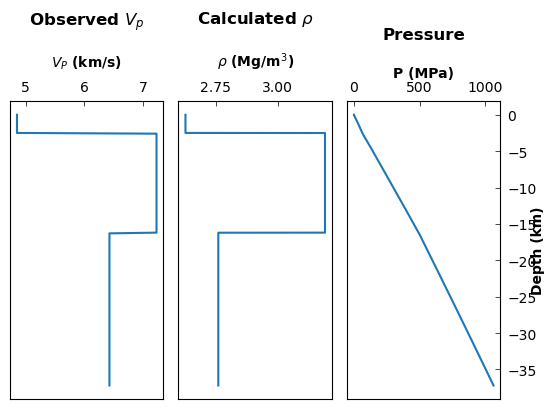

In [12]:
# data1, data2 and data3 -- list of dictionaries for each panel for each data series.
data1 = [{'x': profile_stephenson["Vp_hi_res"][:,1], 'y': profile_stephenson["Vp_hi_res"][:,0]}]
data2 = [{'x': profile_stephenson["rho"][:,1], 'y': profile_stephenson["rho"][:,0]}]
data3 = [{'x': profile_stephenson["p"][:,1], 'y': profile_stephenson["p"][:,0]}]

# Call the plot_panels function
smplt.plot_panels([data1, data2, data3], plot_type=plot_type, 
            cmap=None, titles=titles, 
            xlabels=xlabels, ylabels=ylabels,
            z_values=None, figure_scale=0.7, 
            save_path=None)

## Summary

We have converted a Vp file to density using the `SMV2rho`, or `stephenson` approach without including any temperature dependence.  We have explored approaches to carrying out this conversion using both a class- and method-based approach.  We have checked that the outputs from these two approaches in the same by plotting.